In [1]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.inspection import permutation_importance
from sklearn.naive_bayes import GaussianNB

import lime
import lime.lime_tabular
from lime.lime_tabular import LimeTabularExplainer 

#from pdpbox import pdp, info_plots

import matplotlib.pyplot as plt
import seaborn as sns

import eli5
from eli5.sklearn import PermutationImportance

import pickle

sns.set_style(style="ticks")
sns.set_palette(sns.color_palette("Dark2"))

plt.rcParams["figure.figsize"] = [12, 8]
plt.rcParams["figure.autolayout"] = True 
plt.rcParams["xtick.alignment"] = 'center'
plt.rcParams["ytick.alignment"] = 'center'

from os.path import isfile

from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
#print(plt.rcParams.keys())

**Вспомогательные функции и определения.**

In [2]:
colors = {
    0: 'orange',
    1: 'green',
}

labels = {
    0: 'Healthy',
    1: 'Sick'
}

n_class = 2

col_names = [
    'age', 'sex', 'chest_pain_type', 'rst_blood_pressure', 'serum_cholestoral', 'fasting_blood_sugar', 
    'rst_ecg_results', 'max_heart_rate', 'exercise_induced_angina', 'depression_induced_by_exercise', 
    'slope_of_peak_exercise', 'number_of_major_vessels', 'thalassemia', 'healthy', 'health_state'
]

Я решил использовать более-менее полные имена, чтобы "понимать" их значение. Сокращения лично мне понимать крайне сложно.

In [61]:
def get_thershold_predict(predictions: np.array, threshold: float):
    result = []
    
    for val in predictions:
        if val[0] >= threshold:
            result.append(0)
        else:
            result.append(1)
    
    return np.array(result)
    

In [4]:
def plot_roc(predict_proba: np.array, test: np.array, name: str, n_class: int, colors: list, labels: list, fig_size: tuple):
    fp, tp, thr = {}, {}, {}
    
    f, ax = plt.subplots(1, figsize=fig_size)
    plt.title(name)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    
    for i in range(n_class):
        fp[i], tp[i], thr[i] = roc_curve(test, predict_proba[:,i], pos_label=i)
        plt.plot(fp[i], tp[i], linestyle='--',color=colors[i], label=labels[i])
    
    plt.show()

**Импорт данных**

In [5]:
exclude_lines = [i for i, line in enumerate(open('./data/src/cleve.mod')) if line.startswith('%')]

src_cleve_df = pd.read_csv(
    filepath_or_buffer='./data/src/cleve.mod',
    delimiter=' ',
    names=col_names,
    skiprows=exclude_lines,
    skipinitialspace=True,
    na_values=['?', -9]
)

In [6]:
src_cleve_df.head()

,age,sex,chest_pain_type,rst_blood_pressure,serum_cholestoral,fasting_blood_sugar,rst_ecg_results,max_heart_rate,exercise_induced_angina,depression_induced_by_exercise,slope_of_peak_exercise,number_of_major_vessels,thalassemia,healthy,health_state
0,63.0,male,angina,145.0,233.0,true,hyp,150.0,fal,2.3,down,0.0,fix,buff,H
1,67.0,male,asympt,160.0,286.0,fal,hyp,108.0,true,1.5,flat,3.0,norm,sick,S2
2,67.0,male,asympt,120.0,229.0,fal,hyp,129.0,true,2.6,flat,2.0,rev,sick,S1
3,37.0,male,notang,130.0,250.0,fal,norm,187.0,fal,3.5,down,0.0,norm,buff,H
4,41.0,fem,abnang,130.0,204.0,fal,hyp,172.0,fal,1.4,up,0.0,norm,buff,H


In [7]:
src_cleve_df.isna().sum()

age                               0
sex                               0
chest_pain_type                   0
rst_blood_pressure                0
serum_cholestoral                 0
fasting_blood_sugar               0
rst_ecg_results                   0
max_heart_rate                    0
exercise_induced_angina           0
depression_induced_by_exercise    0
slope_of_peak_exercise            0
number_of_major_vessels           5
thalassemia                       2
healthy                           0
health_state                      0
dtype: int64

In [8]:
src_cleve_df.shape

(303, 15)

In [9]:
sex = {
    'male': 1,
    'fem':  0
}

# chest pain type
cp = {
    'angina': 1, #typical angina
    'abnang': 2, #atypical angina 
    'notang': 3, #non-anginal pain
    'asympt': 4  #asymptomatic
}

#fasting blood sugar > 120 mg/dl
fbs = {
    'fal':  0,
    'true': 1
}

#resting electrocardiographic results
restecg = {
    'norm': 0, #normal
    'abn':  1, #having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
    'hyp':  2  #showing probable or definite left ventricular hypertrophy by Estes' criteria
}

#exercise induced angina (1 = yes; 0 = no)
exang = {
    'fal':  0,
    'true': 1    
}
#the slope of the peak exercise ST segment
slope = {
    'up':   1,
    'flat': 2,
    'down': 3
}


thal = {
    'norm': 3, #normal
    'fix':  6, #fixed defect
    'rev':  7  #reversable defect
}
        
healthy = {
    'buff': 0,
    'sick': 1
}

health_state = {
    'H':  0,
    'S1': 1,
    'S2': 2,
    'S3': 3,
    'S4': 4,
}

In [10]:
X = pd.DataFrame()

X['age'] = src_cleve_df.dropna()['age']
X['sex'] = [sex[x] for x in src_cleve_df.dropna()['sex']]
X['chest_pain_type'] = [cp[x] for x in src_cleve_df.dropna()['chest_pain_type']]
X['rst_blood_pressure'] = src_cleve_df.dropna()['rst_blood_pressure']
X['serum_cholestoral'] = src_cleve_df.dropna()['serum_cholestoral']
X['fasting_blood_sugar'] = [fbs[x] for x in src_cleve_df.dropna()['fasting_blood_sugar']]
X['rst_ecg_results'] = [restecg[x] for x in src_cleve_df.dropna()['rst_ecg_results']]
X['max_heart_rate'] = src_cleve_df.dropna()['max_heart_rate']
X['exercise_induced_angina'] = [exang[x] for x in src_cleve_df.dropna()['exercise_induced_angina']]
X['depression_induced_by_exercise'] = src_cleve_df.dropna()['depression_induced_by_exercise']
X['slope_of_peak_exercise'] = [slope[x] for x in src_cleve_df.dropna()['slope_of_peak_exercise']]
X['number_of_major_vessels'] = src_cleve_df.dropna()['number_of_major_vessels']
X['thalassemia'] = [thal[x] for x in src_cleve_df.dropna()['thalassemia']]

y = np.array(
    [healthy[x] for x in src_cleve_df.dropna()['healthy']]
)

X['healthy'] = y
X['health_state'] = [health_state[x] for x in src_cleve_df.dropna()['health_state']]

In [11]:
X.head()

,age,sex,chest_pain_type,rst_blood_pressure,serum_cholestoral,fasting_blood_sugar,rst_ecg_results,max_heart_rate,exercise_induced_angina,depression_induced_by_exercise,slope_of_peak_exercise,number_of_major_vessels,thalassemia,healthy,health_state
0,63.0,1,1,145.0,233.0,1,2,150.0,0,2.3,3,0.0,6,0,0
1,67.0,1,4,160.0,286.0,0,2,108.0,1,1.5,2,3.0,3,1,2
2,67.0,1,4,120.0,229.0,0,2,129.0,1,2.6,2,2.0,7,1,1
3,37.0,1,3,130.0,250.0,0,0,187.0,0,3.5,3,0.0,3,0,0
4,41.0,0,2,130.0,204.0,0,2,172.0,0,1.4,1,0.0,3,0,0


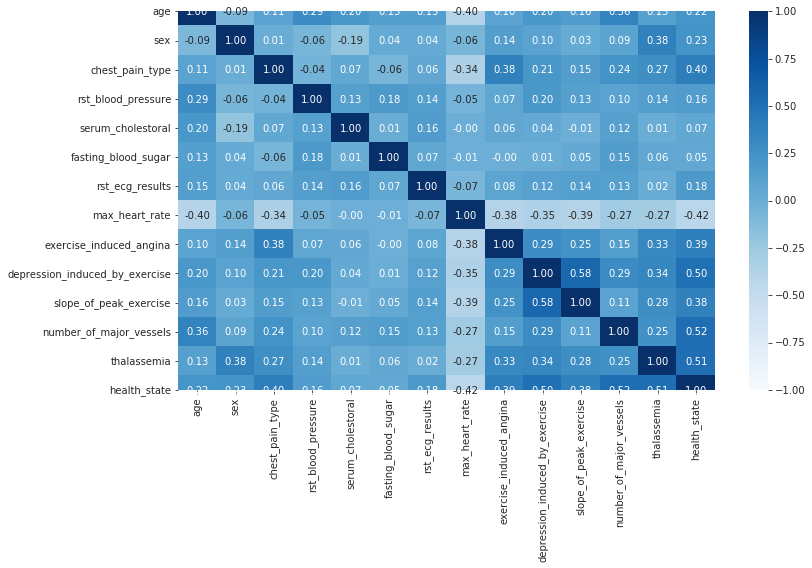

In [12]:
a = sns.heatmap(data=X.loc[:, X.columns != 'healthy'].corr(), annot=True, fmt=".2f", cmap='Blues', vmin=-1.0, vmax=1.0, center=0.0)

Интересно, что максимальный пульс неплохо связан почти со всеми остальными параметрами.

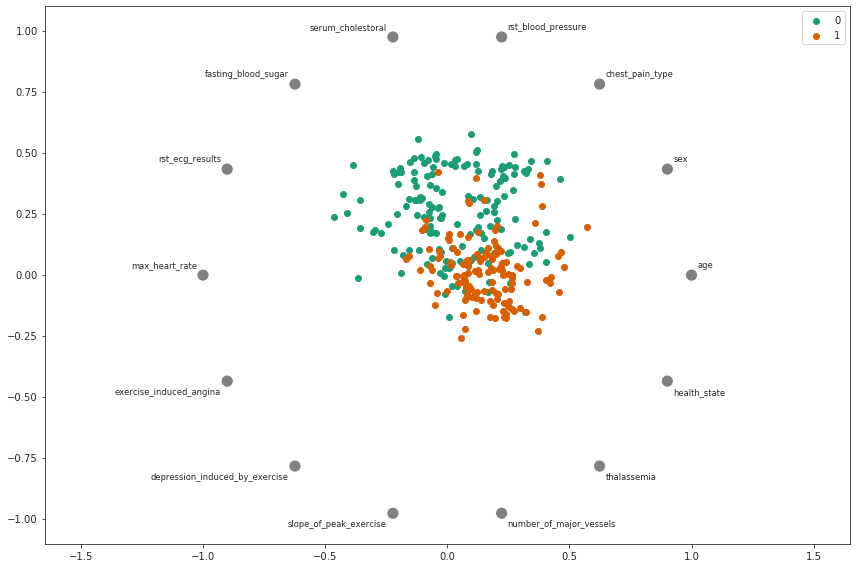

In [13]:
f, ax = plt.subplots(figsize=(12, 8))
a = pd.plotting.radviz(frame=X, class_column='healthy', color=sns.color_palette())

Ничего особенного в данных нет. 

**Модель**

Для начала, я попробую отделить здоровых от больных. Без определения тяжести заболевания, если оно есть.

Попробую наивный Байес и логистическую регрессию. Как самые простые бинарные классификаторы. В качестве базовых моделей.

In [14]:
X_ = X.drop(['healthy', 'health_state'], axis=1)
y_ = y

X_ = pd.DataFrame(StandardScaler().fit_transform(X_), columns=X_.columns)

Подбирать гиперпараметры буду без изысков, полным перебором вариантов.

In [15]:
model_nb = GaussianNB()

if isfile("./data/models/model_nb.pkl"):
    with open("./data/models/model_nb.pkl", "rb") as m_file:
        model_nb = pickle.load(m_file)
else:
    model_nb_best = GaussianNB()
    
    cross_val = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)

    best_score = 0
    for train_index, test_index in cross_val.split(X_, y_):
        X_train, X_test = X_.iloc[train_index], X_.iloc[test_index]
        y_train, y_test = y_[train_index], y_[test_index]
        
        model_nb.fit(X_train, y_train)
        model_nb_pred = model_nb.predict(X_test)
        
        score = roc_auc_score(y_test, model_nb_pred)
        
        if score > best_score:
            best_score = score
            model_nb_best = model_nb
    
    model_nb = model_nb_best
    with open("./data/models/model_nb.pkl", "wb") as m_file:
        pickle.dump(model_nb_best, m_file)

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X_, y_, test_size=0.2, shuffle=True, stratify=y_, random_state=42)

In [36]:
lr_result = None

if isfile("./data/models/model_lr.pkl"):
    with open("./data/models/model_lr.pkl", "rb") as m_file:
        lr_result = pickle.load(m_file)
else:
    model_lr = LogisticRegression()
    
    c_values = np.arange(1, 100, 1)
    l1_ratio = np.arange(0.1, 0.9, 0.1)
    
    
    params = [
        {'solver': ['sag'], 'penalty': ['l2'], 'C': c_values},
        {'solver': ['sag'], 'penalty': ['none']},
        {'solver': ['newton-cg'], 'penalty': ['l2'], 'C': c_values},
        {'solver': ['newton-cg'], 'penalty': ['none']},
        {'solver': ['lbfgs'], 'penalty': ['l2'], 'C': c_values},
        {'solver': ['lbfgs'], 'penalty': ['none']},
        {'solver': ['saga'], 'penalty': ['l2', 'l1'], 'C': c_values},
        {'solver': ['saga'], 'penalty': ['elasticnet'], 'C': c_values, 'l1_ratio': l1_ratio},
        {'solver': ['saga'], 'penalty': ['none']}
    ]

    cross_val = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
    
    grid_search = GridSearchCV(estimator=model_lr, param_grid=params, cv=cross_val, scoring='accuracy', error_score=0)
    
    with ignore_warnings(category=ConvergenceWarning):
        lr_result = grid_search.fit(X_train, y_train)
    
    with open("./data/models/model_lr.pkl", "wb") as m_file:
        pickle.dump(lr_result, m_file)

In [37]:
model_nb_pred = model_nb.predict(X_test)
model_lr_pred = lr_result.best_estimator_.predict(X_test)
print('AUC for Naive Bayes :\t{:.8f}'.format(roc_auc_score(y_test, model_nb_pred)))
print('AUC for Logistic Regression :\t{:.8f}'.format(roc_auc_score(y_test, model_lr_pred)))

AUC for Naive Bayes :	0.79687500
AUC for Logistic Regression :	0.79687500


Хм, абсолютно одинаковые AUC... 

In [47]:
model_nb_proba = model_nb.predict_proba(X_test)
model_lr_proba = lr_result.best_estimator_.predict_proba(X_test)

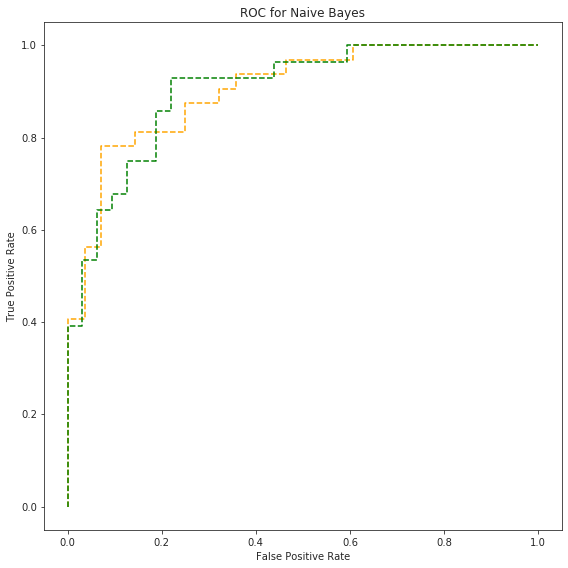

In [48]:
plot_roc(model_nb_proba, y_test, 'ROC for Naive Bayes', 2, colors, labels, (8, 8))

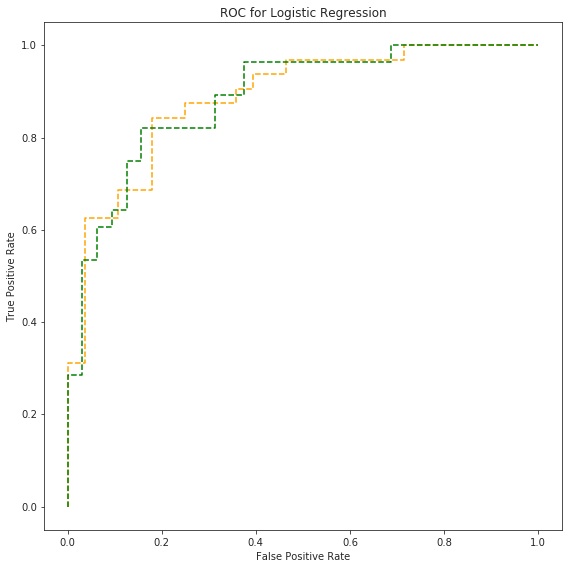

In [49]:

plot_roc(model_lr_proba, y_test, 'ROC for Logistic Regression', 2, colors, labels, (8, 8))

А вот ROC разные. Так и не понял, как такое получается.

In [40]:
print(confusion_matrix(y_test, model_nb_pred))

[[27  5]
 [ 7 21]]


In [41]:
print(confusion_matrix(y_test, model_lr_pred))

[[27  5]
 [ 7 21]]


Интересно, а ошибаются модели в одних и тех-же местах?

In [75]:
nb_lr_compare = []

for idx, val in enumerate(y_test):
    if val != model_lr_pred[idx] or val != model_nb_pred[idx]:
        row = [y_test[idx], model_lr_pred[idx], model_nb_pred[idx]]
        nb_lr_compare.append(row)
        
print(np.array(nb_lr_compare))
print(len(nb_lr_compare))

[[1 1 0]
 [0 1 0]
 [0 1 1]
 [1 0 0]
 [0 0 1]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [0 1 1]
 [0 1 1]
 [1 0 1]
 [1 0 0]
 [0 1 1]
 [1 0 0]]
14


Нет, значит все-таки совпадение AUC это не глюк, а таки совпадение.

А если с threshold поиграться?

In [83]:
nb_lr_compare = []

model_nb_pred_ = get_thershold_predict(model_nb_proba, 0.9)
model_lr_pred_ = get_thershold_predict(model_lr_proba, 0.9)

for idx, val in enumerate(y_test):
    if val != model_lr_pred_[idx] or val != model_nb_pred_[idx]:
        row = [y_test[idx], model_lr_pred_[idx], model_nb_pred_[idx]]
        nb_lr_compare.append(row)
        
print(np.array(nb_lr_compare))
print(len(nb_lr_compare))
print(len(y_test))

[[0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 1]
 [1 1 0]
 [0 1 1]
 [1 0 0]
 [1 1 0]
 [0 1 1]
 [1 1 0]
 [0 1 0]
 [0 1 1]
 [0 1 1]
 [0 1 0]
 [1 1 0]
 [0 1 0]
 [0 1 1]]
19
60
